# Prophet

Importamos las librerías necesarias.

In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import mlflow
import HydroErr as he

from prophet import Prophet, serialize
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.model_selection import train_test_split

import logging, sys
logging.disable(sys.maxsize) ## Deshabilita INFO 

import warnings
warnings.filterwarnings("ignore") #Evitamos que se muestren warnings

### Cargamos las series temporales
Se carga el archivo con la serie temporal y se realizan los cálculos necesarios según la granularidad deseada. Se ajusta el formato de la serie para trabajar con Prophet.

In [2]:
#Cambiar por la serie a procesar

df = pd.read_csv('C:/Users/alexd/Desktop/TFM/2046-Diaria.csv') #Adaja
#df = pd.read_csv('C:/Users/alexd/Desktop/TFM/8030-Diaria.csv') #Mijares

#Procesamiento

df = df.dropna() #Eliminamos los NaN

df["ds"] =  pd.to_datetime(df["ds"], format="%d/%m/%Y")
df.set_index(df['ds'], inplace=True)

#Serie diaria
df_d = df.resample('D', on='ds').sum()

df_d.index.names = ['ds']
df_d.reset_index(inplace=True)

#Serie mensual
df_m = df.copy()
df_m["y"] = (df_m["y"] * 3600*24)/1000000 #Mensual
df_m = df_m.resample('M', on='ds').sum()

df_m.index.names = ['ds']
df_m.reset_index(inplace=True)

#df_m['cap'] = 50

#Serie anual
df_a = df.copy()
df_a["y"] = (df_a["y"] * 3600*24)/1000000 #Anual
df_a['water_year'] = df_a.ds.dt.year.where(df_a.ds.dt.month < 10, df_a.ds.dt.year + 1) #Definimos el año hidrológico
df_a = df_a.groupby('water_year')[['y']].sum() #Agrupamos por año hidrológico

df_a.index.names = ['ds']
df_a.reset_index(inplace=True)
df_a["ds"] =  pd.to_datetime(df_a["ds"], format="%Y")


In [3]:
#Divimos el set de datos entre entrenamiento y test

test_size = 0.18 #Cambiar

train, test = train_test_split(df_m, shuffle = False, test_size = test_size)

print(f"Number of obs. in train data: {len(train)}")
print(f"Number of obs. in test data: {len(test)}")

Number of obs. in train data: 757
Number of obs. in test data: 167


### Entorno de MLFlow

In [7]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("PROPHET")

<Experiment: artifact_location='mlflow-artifacts:/584113484917880235', creation_time=1676813215933, experiment_id='584113484917880235', last_update_time=1676813215933, lifecycle_stage='active', name='PROPHET', tags={}>

### Ejecución del modelo - Ajuste al periodo de entrenamiento

In [34]:
%%time
#Definimos la función para extraer los hiperparámetros del modelo de Prophet a ejecutar para guardarlos en MLFlow



def extract_params(prophet_model):
    return {attr: getattr(prophet_model, attr) for attr in serialize.SIMPLE_ATTRIBUTES}


with mlflow.start_run():
    

    prophet_model = Prophet(
        
        #Hiperparámetros - Cambiar por los de mejor ajuste
                            #yearly_seasonality='false',
                            #weekly_seasonality='false',
                            seasonality_prior_scale=10,
                            daily_seasonality=False,
                            changepoint_prior_scale=0.015,
                            changepoint_range=0.75,
                            growth='linear',
                            interval_width=0.95
    
                            )
    prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=7, prior_scale=10, mode ='multiplicative')
    prophet_model.fit(train)
    
    mlflow.prophet.log_model(prophet_model, registered_model_name = 'Mijares-Mensual', artifact_path = 'prophet-model') # Cambiar el nombre del modelo

    mlflow.log_params(extract_params(prophet_model))
    
    # Creamos el array con el periodo para el que queremos realizar la predicción
    prediction_period = prophet_model.make_future_dataframe(periods = len(test), freq ='MS', include_history=True)

    # Se realiza la predicción
    forecast = prophet_model.predict(prediction_period)
    
    # Valoramos el ajuste con las métricas
    real = df_m['y']
    real = real.set_axis(df_m['ds'])
    
    forecast.yhat[forecast.yhat.lt(0)] = 0 # Se eliminan los valores negativos predictivos

    predictions = forecast.iloc[-len(test):]['yhat']
    predictions = predictions.set_axis(forecast.iloc[-len(test):]['ds'])
    fits = forecast.iloc[:len(train)]['yhat']
    fits = fits.set_axis(forecast.iloc[:len(train)]['ds'])
    actuals = test['y']
    actuals = actuals.set_axis(forecast.iloc[-len(test):]['ds'])
    
    RMSE = he.rmse(predictions, actuals)
    MAE = he.mae(predictions, actuals)
    NSE = he.nse(predictions, actuals)

    
    mlflow.log_metric('RMSE', RMSE)
    mlflow.log_metric('MAE', MAE)
    mlflow.log_metric('NSE', NSE)
    mlflow.log_metric('Test_size', test_size)



Registered model 'Mijares-Mensual' already exists. Creating a new version of this model...
Created version '14' of model 'Mijares-Mensual'.


CPU times: total: 1.72 s
Wall time: 4.89 s


### Predicción con el modelo ajustado

In [82]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
919,2019-05-01,13.949807,-17.750381,47.019632
920,2019-06-01,10.380900,-21.290384,41.957248
921,2019-07-01,2.044590,-30.062851,33.507577
922,2019-08-01,0.000000,-34.345048,26.005143
923,2019-09-01,0.000000,-36.013208,24.089881


### Coeficientes

In [35]:
print('El valor de MAE obtenido es: '+str(MAE))
print('El valor de RMSE obtenido es: '+str(RMSE))
print('El valor de NSE obtenido es: '+str(NSE))

El valor de MAE obtenido es: 5.113233862991699
El valor de RMSE obtenido es: 7.752165610750277
El valor de NSE obtenido es: 0.03865532298174612


### Gráfico de resultados

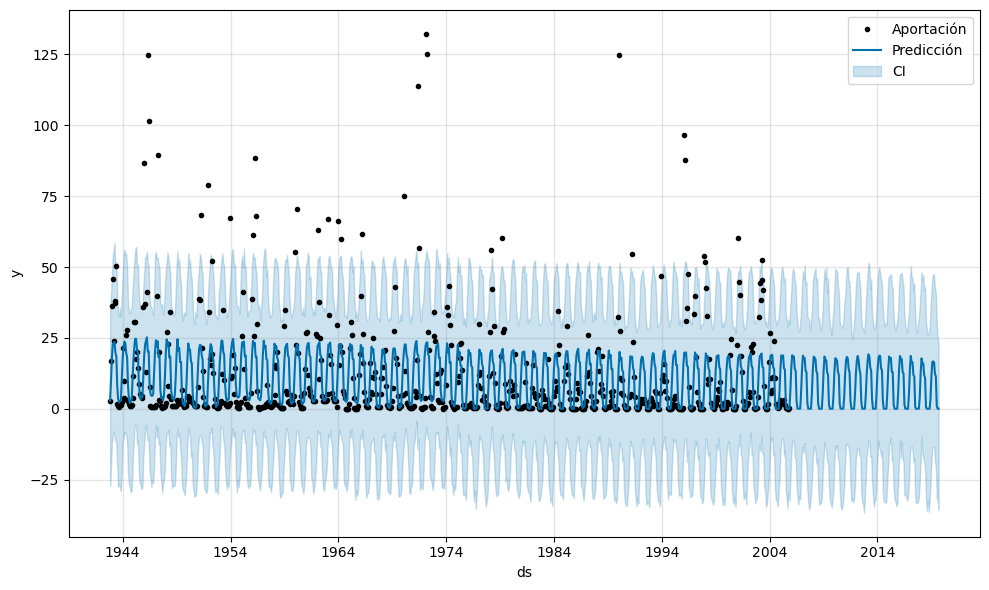

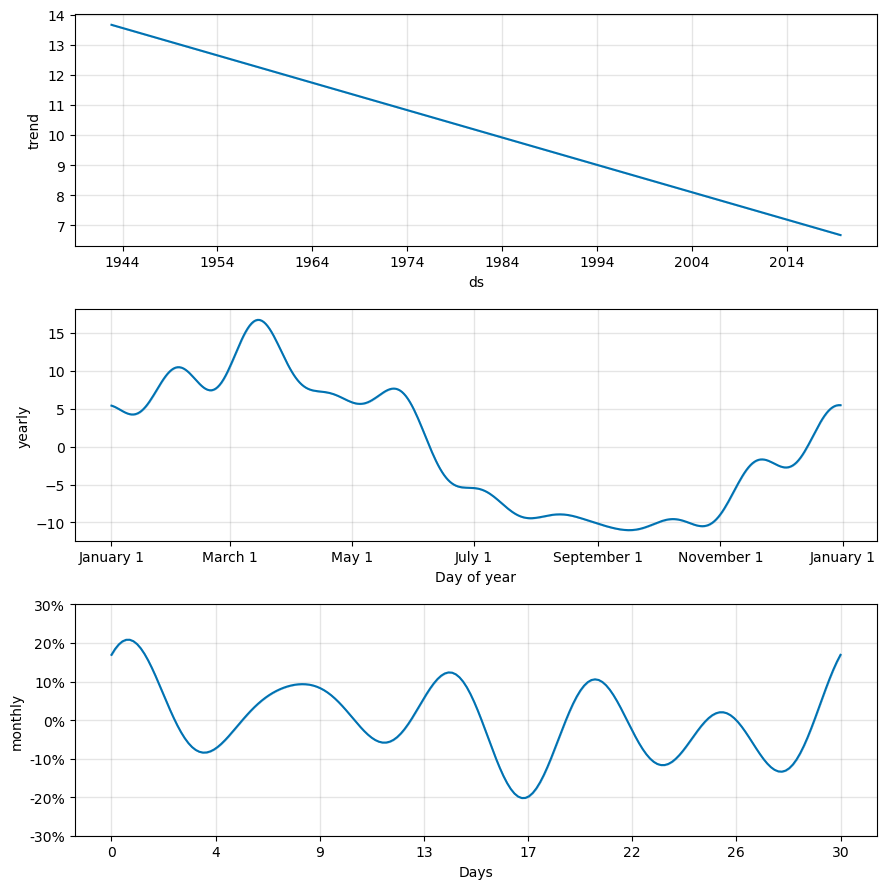

In [41]:
fig1 = prophet_model.plot(forecast)
plt.legend(['Aportación', 'Predicción', 'CI'])
plt.show()

fig2 = prophet_model.plot_components(forecast)


### Cambios de tendencia

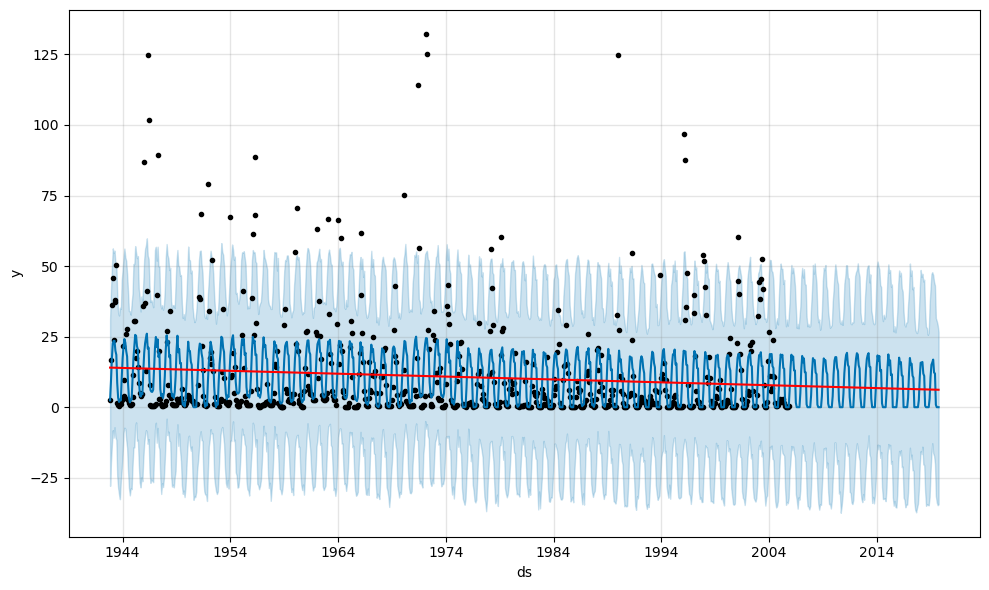

In [143]:
#Cambios de tendencia
fig = prophet_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_model, forecast)

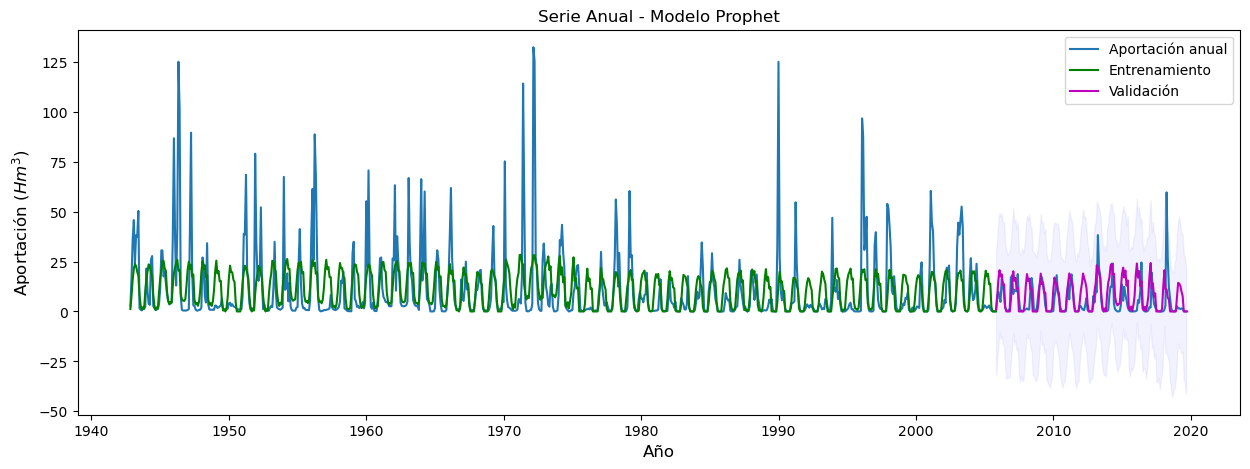

In [22]:
#Mostramos la gráfica con la predicción

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(real, linestyle = 'solid')
ax.plot(fits, color = 'green',linestyle = 'solid')
ax.plot(predictions, color = 'm',linestyle = 'solid')
ax.fill_between(predictions.index,
                forecast.iloc[-len(test):]['yhat_lower'],
                forecast.iloc[-len(test):]['yhat_upper'],color='blue',alpha=.05)

plt.title('Serie Anual - Modelo Prophet')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Aportación ($Hm^3$)', fontsize=12)
plt.legend(['Aportación anual','Entrenamiento','Validación'])


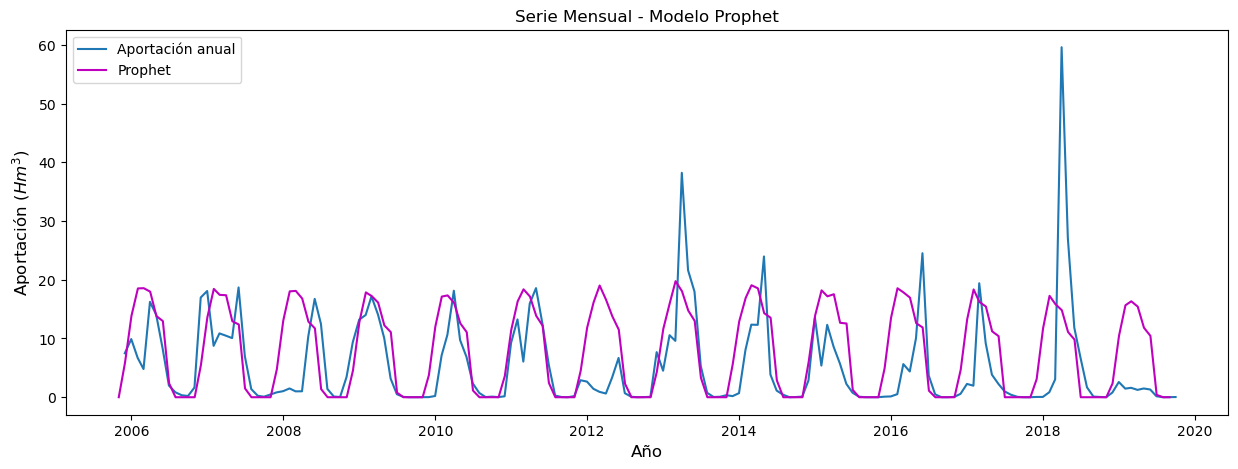

In [36]:
#Mostramos la gráfica con la predicción

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(real.iloc[-len(test):], linestyle = 'solid')
ax.plot(predictions, color = 'm',linestyle = 'solid')
#ax.fill_between(predictions.index,
                #forecast.iloc[-len(test):]['yhat_lower'],
                #forecast.iloc[-len(test):]['yhat_upper'],color='blue',alpha=.05)

plt.title('Serie Mensual - Modelo Prophet')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Aportación ($Hm^3$)', fontsize=12)
plt.legend(['Aportación anual','Prophet'])


In [136]:
#Guardamos los resultados del modelo Prophet

model_results = pd.concat([predictions, real.iloc[-len(test):]], axis=1)
model_results.rename(columns = {0:'Forecast', 1:'Test'}, inplace = True)
model_results

#Adaja
#model_results.to_excel(r'C:/Users/alexd/Desktop/TFM/Resultados2046_ARIMA_Anual.xlsx', index=True)

#Mijares
model_results.to_excel(r'C:/Users/alexd/Desktop/TFM/Resultados2046_PROPHET_Mensual.xlsx', index=True)

### Grid search - Cross Validation

In [4]:
%%time
#Grid search

initial = str(len(train)*365) # Igual al número de años del set de validación


param_grid = {  
    
    'yearly_seasonality': ['auto'],
    'weekly_seasonality': ['auto'],                    
    'daily_seasonality': [False],
    'changepoint_prior_scale': [0.001,0.015,0.05,0.5,0.1,0.005,5,10],
    'changepoint_range': [0.70, 0.80, 0.85, 0.90],
    'growth': ['linear'],
    
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
coefficients = []  # Store the coefficients for each params here
coefficients_1 = []

# Use cross validation to evaluate all parameters
for params in all_params:
    
    prophet_model = Prophet(**params).fit(df_m)
    #prophet_model = Prophet(**params).add_seasonality(name='monthly', period=30.5, fourier_order=6, prior_scale=10, mode ='multiplicative').fit(df_m)  # Fit model with given params (Cambiar dataframe según escala temporal)
    df_cv = cross_validation(prophet_model, initial=initial, period='1825 days', horizon = '1825 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p['nse']=1-(df_p['rmse']/np.std(df_cv['y']))**2
    
    coefficients.append(df_p['nse'].values[0]) #Cambiar mape por métrica de ajuste
    coefficients_1.append(df_p['rmse'].values[0]) #Cambiar mape por métrica de ajuste

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['nse'] = coefficients #Cambiar mape por métrica de ajuste
tuning_results['rmse'] = coefficients_1 #Cambiar mape por métrica de ajuste
print(tuning_results)

   yearly_seasonality weekly_seasonality  daily_seasonality  \
0                auto               auto              False   
1                auto               auto              False   
2                auto               auto              False   
3                auto               auto              False   
4                auto               auto              False   
5                auto               auto              False   
6                auto               auto              False   
7                auto               auto              False   
8                auto               auto              False   
9                auto               auto              False   
10               auto               auto              False   
11               auto               auto              False   
12               auto               auto              False   
13               auto               auto              False   
14               auto               auto              F

In [5]:
#Mostrar mejor resultado
best_params = all_params[np.argmax(coefficients)]
print(best_params)

{'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'daily_seasonality': False, 'changepoint_prior_scale': 0.5, 'changepoint_range': 0.85, 'growth': 'linear'}


In [7]:
str(len(train)*365) # Igual al número de años del set de validación

'276305'

## Predicciones

In [14]:
#Cambiar hiperparámetros y periodo de predicción

prophet_model = Prophet(
        #Hiperparámetros - Cambiar por los de mejor ajuste
                        yearly_seasonality='auto',
                        weekly_seasonality='auto',
                        #seasonality_prior_scale=10,
                        daily_seasonality=False,
                        changepoint_prior_scale=0.01,
                        changepoint_range=0.70,
                        growth='linear',
                        interval_width=0.95
    
                        )
#prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=7, prior_scale=10, mode ='multiplicative')
prophet_model.fit(df_m)

prediction_period = prophet_model.make_future_dataframe(periods = 24, freq ='MS', include_history=False)
forecast = prophet_model.predict(prediction_period)
forecast.yhat[forecast.yhat.lt(0)] = 0 # Se eliminan los valores negativos predictivos
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-10-01,1.047382,-4.301098,5.303047,1.047382,1.047382,-0.670788,-0.670788,-0.670788,-0.670788,-0.670788,-0.670788,0.0,0.0,0.0,0.376594
1,2019-11-01,1.044752,-3.911216,5.815450,1.044752,1.044752,0.137060,0.137060,0.137060,0.137060,0.137060,0.137060,0.0,0.0,0.0,1.181812
2,2019-12-01,1.042206,-4.235284,5.248862,1.042206,1.042206,-0.483584,-0.483584,-0.483584,-0.483584,-0.483584,-0.483584,0.0,0.0,0.0,0.558623
3,2020-01-01,1.039576,-4.366426,5.973645,1.039575,1.039577,-0.291710,-0.291710,-0.291710,-0.291710,-0.291710,-0.291710,0.0,0.0,0.0,0.747866
4,2020-02-01,1.036946,-3.632532,6.555946,1.036944,1.036948,0.230056,0.230056,0.230056,0.230056,0.230056,0.230056,0.0,0.0,0.0,1.267002
5,2020-03-01,1.034485,-3.688096,6.039526,1.034482,1.034490,0.023177,0.023177,0.023177,0.023177,0.023177,0.023177,0.0,0.0,0.0,1.057663
6,2020-04-01,1.031855,-3.548745,6.073217,1.031851,1.031861,0.176476,0.176476,0.176476,0.176476,0.176476,0.176476,0.0,0.0,0.0,1.208331
7,2020-05-01,1.029310,-3.788811,5.458133,1.029304,1.029318,-0.004616,-0.004616,-0.004616,-0.004616,-0.004616,-0.004616,0.0,0.0,0.0,1.024693
8,2020-06-01,1.026680,-3.023595,6.610681,1.026672,1.026690,0.685578,0.685578,0.685578,0.685578,0.685578,0.685578,0.0,0.0,0.0,1.712258
9,2020-07-01,1.024134,-2.854190,6.999421,1.024125,1.024148,0.794436,0.794436,0.794436,0.794436,0.794436,0.794436,0.0,0.0,0.0,1.818570


# NeuralProphet

In [ ]:
    n_lags=6,
    n_forecasts=12,
    changepoints_range=0.80,
    n_changepoints=40,
    weekly_seasonality=False,
    seasonality_mode="multiplicative",

In [7]:
from neuralprophet import NeuralProphet


df = df_a

m = NeuralProphet(

)

#m.add_seasonality(name='monthly', period=30.5, fourier_order=6)

metrics = m.fit(df, freq="Y")

forecast = m.predict(df)

predictions = forecast.iloc[-len(test):]['yhat1']

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch[638/638]: 100%|█████████████| 638/638 [00:13<00:00, 47.60it/s, SmoothL1Loss=0.0322, MAE=56.6, RMSE=72, RegLoss=0]


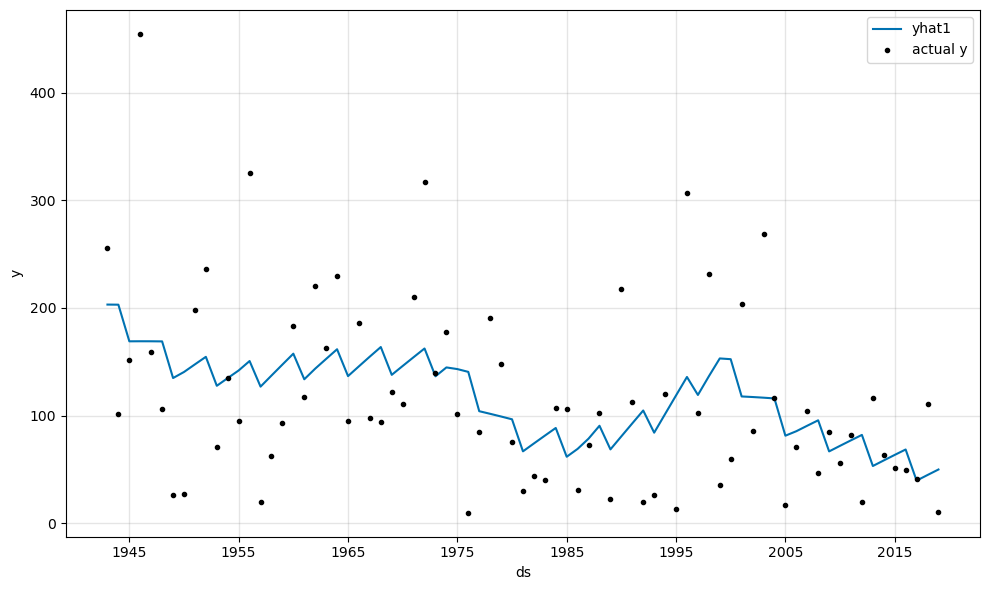

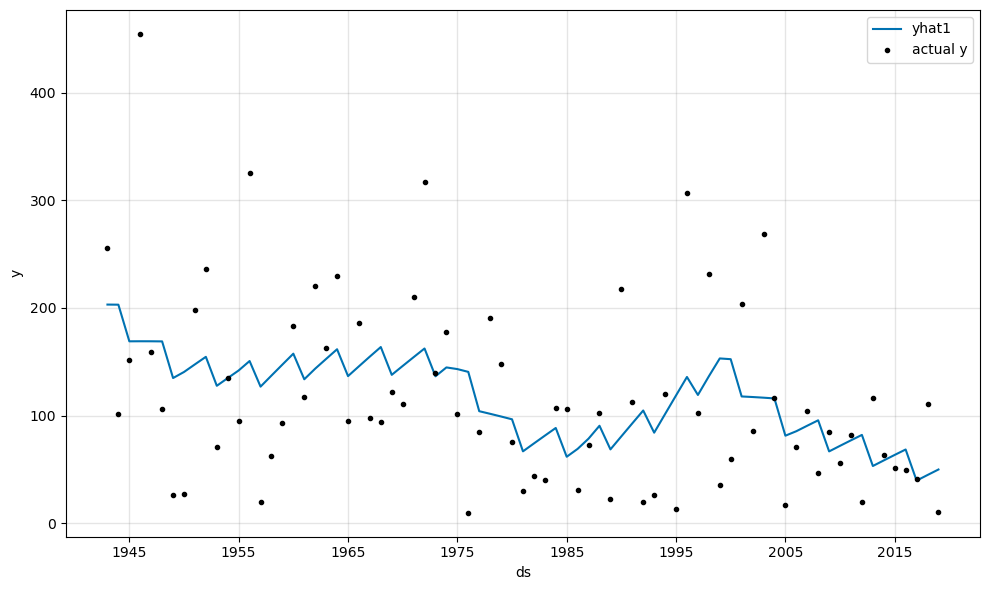

In [8]:
m.plot(forecast)

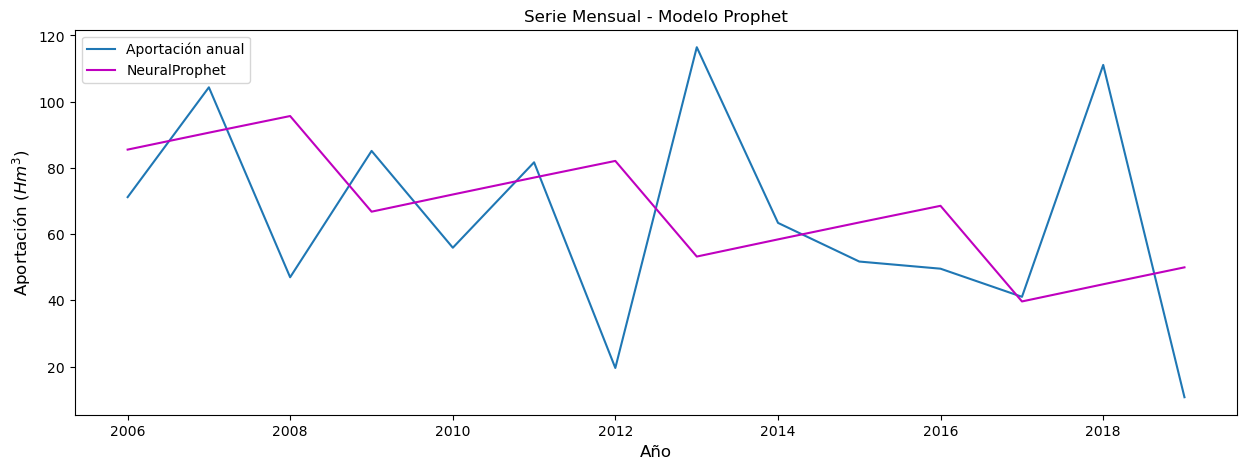

In [9]:
#Mostramos la gráfica con la predicción
real = df_a['y']
real = real.set_axis(df_a['ds'])
forecast.yhat1[forecast.yhat1.lt(0)] = 0
predictions = forecast.iloc[-len(test):]['yhat1']
predictions = predictions.set_axis(forecast.iloc[-len(test):]['ds'])

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(real.iloc[-len(test):], linestyle = 'solid')
ax.plot(predictions, color = 'm',linestyle = 'solid')
#ax.fill_between(predictions.index,
                #forecast.iloc[-len(test):]['yhat_lower'],
                #forecast.iloc[-len(test):]['yhat_upper'],color='blue',alpha=.05)

plt.title('Serie Mensual - Modelo Prophet')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Aportación ($Hm^3$)', fontsize=12)
plt.legend(['Aportación anual','NeuralProphet'])

In [54]:
forecast

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,ar6,ar7,ar8,ar9,ar10,ar11,ar12,trend,season_yearly,season_monthly
0,1942-10-31,2.690064,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,1942-11-30,16.709933,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,1942-12-31,36.137664,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,1943-01-31,45.742061,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,1943-02-28,23.807174,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,2019-05-31,1.315094,6.341853,5.026759,6.279499,4.964405,6.709461,5.394366,7.002167,5.687073,...,-6.224559,-6.342837,-6.206818,-5.824403,-5.755776,-5.987545,-6.13862,10.276306,0.178229,0.086754
920,2019-06-30,0.168566,7.545443,7.376877,7.942847,7.774281,8.135354,7.966788,7.886363,7.717796,...,-2.895909,-3.186575,-3.485777,-3.606994,-3.450195,-3.498558,-3.21874,10.192562,-0.176382,0.227922
921,2019-07-31,0.000000,3.666332,3.666332,5.060644,5.060644,5.061315,5.061315,5.042693,5.042693,...,-2.269291,-2.9317,-3.297083,-3.552093,-3.535724,-3.418402,-3.375654,10.106027,-0.372881,0.086754
922,2019-08-31,0.015379,3.160304,3.144925,4.319727,4.304348,4.462751,4.447372,4.486962,4.471583,...,-1.485425,-1.786152,-2.707785,-2.794816,-3.026874,-2.941803,-2.871043,10.019496,-0.3593,-0.116914


In [63]:
#Guardamos los resultados del modelo Prophet

model_results = pd.concat([predictions, real.iloc[-len(test):]], axis=1)
model_results.rename(columns = {0:'Forecast', 1:'Test'}, inplace = True)
model_results

#Adaja
#model_results.to_excel(r'C:/Users/alexd/Desktop/TFM/Resultados2046_ARIMA_Anual.xlsx', index=True)

#Mijares
model_results.to_excel(r'C:/Users/alexd/Desktop/TFM/Resultados8030_NPROPHET_Mensual.xlsx', index=True)